# Bike Rental Case
### Data Science Project

#### Project Summary
Wheelie Wonka, a rental bike company from Boston, puts their users first. To enhance their mobile app experience, they would like to show bike availability in the future to their users. An important component in achieving this goal is to predict, at the beginning of a bike trip, the trip duration in Boston, MA, USA.
To make these predictions, Wheelie Wonka has provided data about the bike trips, the bike stations and weather information as recorded by a nearby weather station.

The project follows the steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Data Pre-processing and Feature Creation
* Step 4: Model Design and Evaluation

IMPORTANT: For core code used in this script, please refer to .py scripts provided with this project.

### Step 1: Scope the Project and Gather Data

#### Scope 
This projects aims to analyze Wheelie Wonka users behavior through provided data sources.
The goal is to explore and discover interesting patterns in data, perform data cleaning, feature engineering and build ML model to predict trip duration for each trip.
#### Describe and Gather Data 
This bike-rental company has provided following data sources:
* Hubway Sations: Dimensional table containing station properties
* Hubway Trips: Fact table containing user activity properties
* Weather Data: Fact table containing weather properties. 

IMPORTANT: Since provided Boston weather dataset matched only 30% of weather information on user activity, a new dataset with 100% of data coverage has been discovered on [this](https://www.kaggle.com/jqpeng/boston-weather-data-jan-2013-apr-2018/version/2) source.

#### Import Dependencies and Data Sources
This section imports data sets and necessary code sources for the entire project.

In [111]:
# include all libraries needed for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_processing as dpr
import data_plotting as dpl
import ml_processing as ml
import xgboost as xgb
from dateutil.parser import parse
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# import raw datasets
hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df = dpr.importData()

In [3]:
# merge all datasets into master data set
master_df = dpr.createMasterDataSet(hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df)

### Step 2: Explore and Assess the Data

#### Scope 
This step includes key insights and derived features on user behaviour in following steps:

* Feature Set Creation: Build essential features based on resulting insights
* Overall Analysis: Key insights regarding users and stations
* Geo Spatial Analysis: Important spatial insights on station locations and user interactions
* Distribution Analysis: Key insights on frequency distribution accross different features
* Comparative Analysis per User Type: Stacked histograms on differend features (registered vs casual users)
* Comparative Analysis per Gender: Stacked histograms on differend features (women vs men)


#### Feature Set Creation
Build essential features based on resulting insights

In [4]:
# Create additional features derived from exploratory analysis
# Complete list of selected features will be elaborated in Step3
# This is a final product of features to be used for data preparation in ML process
master_df = dpr.createFeatures(master_df)

#### Overall Analysis
Key insights regarding users and stations

In [5]:
# List all municipalities within Boston City (a starting station municipality is chosen as aggregation point)
municipal_start_counts = master_df[['municipal_start', 'seq_id']].groupby(by=['municipal_start']).agg(ride_cnt=('seq_id', 'count')).sort_values(['ride_cnt'], ascending=False).reset_index()
municipal_start_counts=municipal_start_counts.join(municipal_start_counts[['ride_cnt']].apply(lambda x:100 * x / float(x.sum())).rename(columns={'ride_cnt': 'ride_pct'}))
print('Boston municipalities share of bike rides:\r\n', municipal_start_counts)

Boston municipalities share of bike rides:
   municipal_start  ride_cnt   ride_pct
0          Boston   1165665  77.052713
1       Cambridge    288706  19.084025
2      Somerville     38457   2.542082
3       Brookline     19987   1.321179


In [6]:
# Number of available bikes
print('Number of different bikes available for use: ', master_df.bike_nr.nunique())

Number of different bikes available for use:  1163


In [7]:
# Number of stations
print('Number of different bike stations: ', hubway_stations_df.id.nunique())

# Existing vs removed stations
print('Number of different bike stations per status:\r\n', hubway_stations_df.groupby('status').id.nunique())

Number of different bike stations:  142
Number of different bike stations per status:
 status
Existing    130
Removed      12
Name: id, dtype: int64


In [8]:
# Share of bike rides that start and finish at the same station
same_st_flg_counts = master_df[['same_st_flg', 'seq_id']].groupby(by=['same_st_flg']).count().reset_index().sort_values(['seq_id'], ascending=False)
same_st_flg_ratio = same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 1].iloc[0]/same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 0].iloc[0]
print("Share of bike rides that start and finish at the same station: ", round(same_st_flg_ratio*100,2), '%')

Share of bike rides that start and finish at the same station:  3.38 %


In [9]:
# Number of available bikes
print('Share of Casual vs Registered Users: \r\n', master_df.groupby('subsc_type').seq_id.nunique())

Share of Casual vs Registered Users: 
 subsc_type
Casual         417138
Registered    1095689
Name: seq_id, dtype: int64


#### Geo Spatial Analysis
Spatial insights on station locations and user interactions

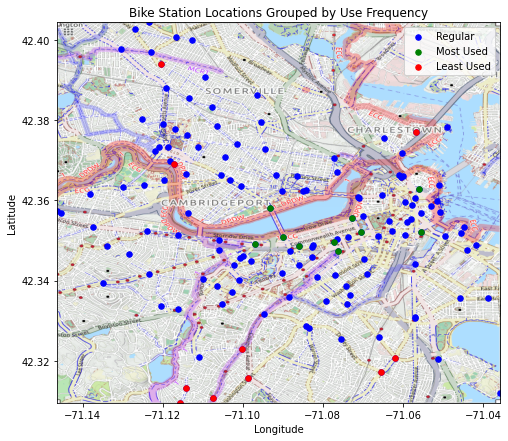

In [10]:
# Display bike station locations across Boston City Cycle Map
# Map was extracted from OpenStreetMap service
# Map shows regular, top 10 least used and top 10 most used bike stations
# Tip: Most frequently used stations should provide more available bikes 
# and closer service center(s) for faster bike repairs during a high season.
dpl.plotSpatialDataAllStations(master_df, hubway_stations_df)

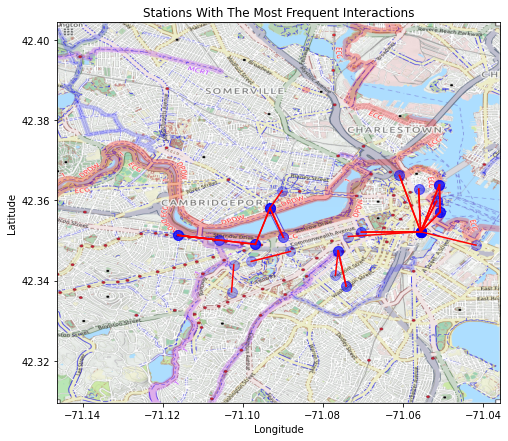

In [11]:
# Display bike station pairs with highest user interactions
# The connection resambles most common take and drop-off station pairs
dpl.plotSpatialDataStationInteractions(master_df, hubway_stations_df)

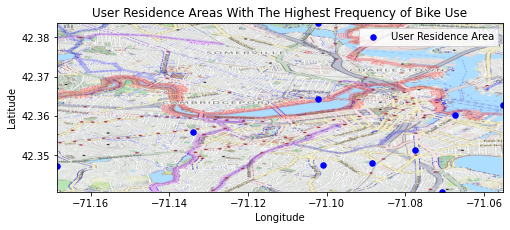

In [12]:
# Display registered user residence areas (based on approximate user zip code) that have increased tendency for bike use
dpl.plotSpatialDataUserZIPCodes(zip_code_gps_df)

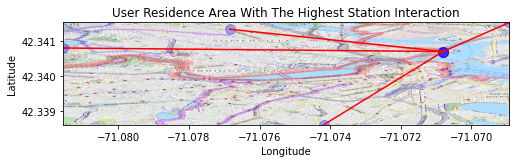

In [13]:
# Display registered user residence area with the highest tendency for bike use and 4 most frequent bike station interactions
dpl.plotSpatialDataUserZIPCodeInteractions(master_df)

#### Distribution Analysis
Key insights on frequency distribution accross different features

##### Trip Duration
An interesting finding here is that registered users from Brookline and Somerville tend to use bikes longer.
This fact makes sense since these 2 municipalities are a bit far away from city centre comparing to other 2 municipalities and users might want to have a bike trip closer to city centre.

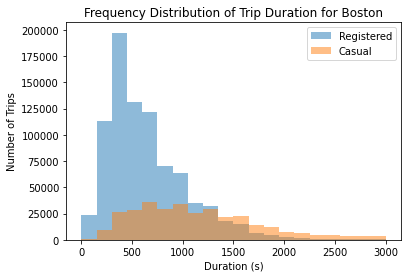

In [14]:
# Display trip duration frequency distribution across user types for Boston
dpl.plotHistDistDuration(master_df, 'Boston')

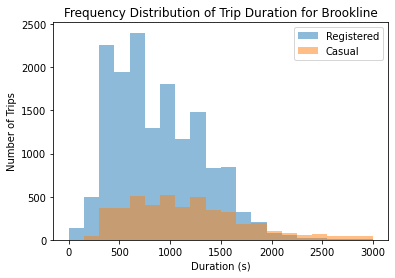

In [15]:
# Display trip duration frequency distribution across user types for Brookline
dpl.plotHistDistDuration(master_df, 'Brookline')

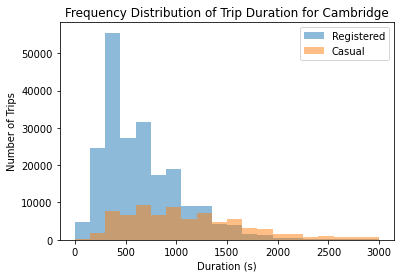

In [16]:
# Display trip duration frequency distribution across user types for Cambridge
dpl.plotHistDistDuration(master_df, 'Cambridge')

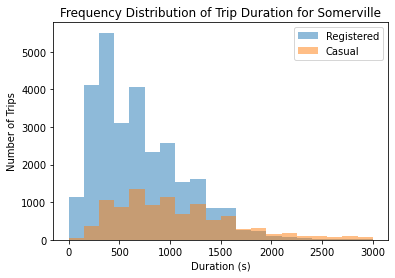

In [17]:
# Display trip duration frequency distribution across user types for Somerville
dpl.plotHistDistDuration(master_df, 'Somerville')

##### Weather Impact
Weather impact on user tendency for bike use fits into expected intervals:

* Temperature (F): 60-80
* Humidity (%): 50-70
* Wind (mph): 5-10
* Dew Point (F): 50-60
* Visibility (mi): 9-10
* Precip (in): 0-0.1

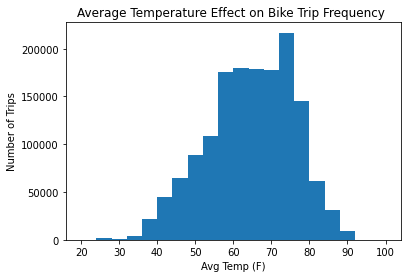

In [18]:
# Display Avg Temp (F) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Temperature Effect on Bike Trip Frequency ', 
                'Avg Temp (F)', 
                'Number of Trips', 
                'Avg Temp (F)', 
                20, 
                100, 
                20)

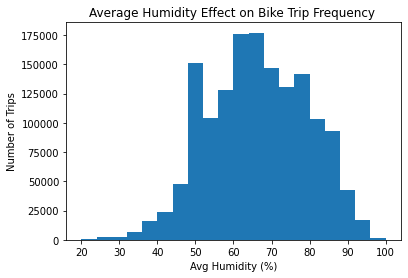

In [19]:
# Display Avg Humidity (%) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Humidity Effect on Bike Trip Frequency ', 
                'Avg Humidity (%)', 
                'Number of Trips', 
                'Avg Humidity (%)', 
                20, 
                100, 
                20)

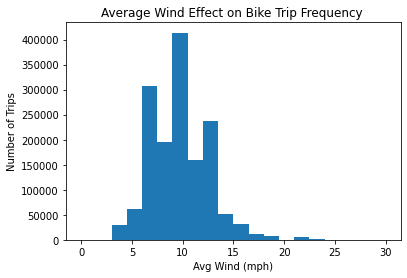

In [20]:
# Display Avg Wind (mph) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Wind Effect on Bike Trip Frequency ', 
                'Avg Wind (mph)', 
                'Number of Trips', 
                'Avg Wind (mph)', 
                0, 
                30, 
                20)

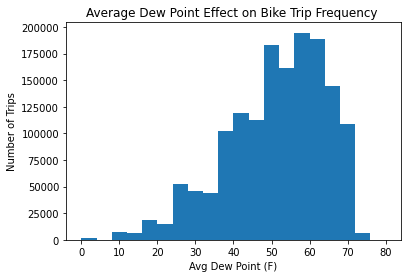

In [21]:
# Display Avg Dew Point (F) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Dew Point Effect on Bike Trip Frequency ', 
                'Avg Dew Point (F)', 
                'Number of Trips', 
                'Avg Dew Point (F)', 
                0, 
                80, 
                20)

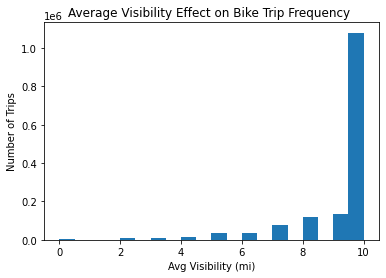

In [22]:
# Display Avg Visibility (mi) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Visibility Effect on Bike Trip Frequency ', 
                'Avg Visibility (mi)', 
                'Number of Trips', 
                'Avg Visibility (mi)', 
                0, 
                10, 
                20)

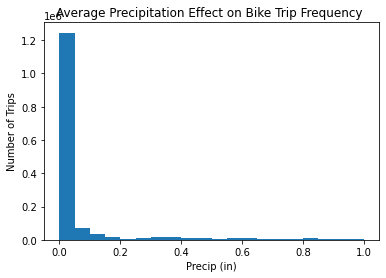

In [23]:
# Display Precip (in) frequency distribution
dpl.plotHistDistVar(master_df, 
                'Average Precipitation Effect on Bike Trip Frequency ', 
                'Precip (in)', 
                'Number of Trips', 
                'Precip (in)', 
                0, 
                1, 
                20)

#### Comparative Analysis per User Type
Key findings:
* Casual users overall tend to take much longer trips vs registered users.
* With increased temperature, trip duration increases too.
* With increasing wind speed, there is no influence on trip duration.
* With increasing humidity, there is a slight increase in trip duration.
* Month of the year has no influence on trip duration among both types of users. August-October period has the highest frequency of bike use and higher tendency of bike use for casual users.
* Snow and rain weather conditions decrease both trip duration and trip frequency among both types of users.




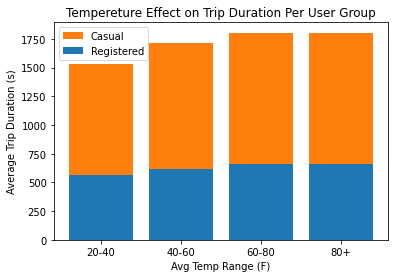

In [24]:
# Display of user type stacked histogram for bike ride time duration for temperature 
# 80+F goup has decreased trend - users tend to limit their trip duration in really hot temperatures
dpl.plotUserTypeStackData(master_df,
                                 'Tempereture Effect on Trip Duration Per User Group',
                                 'Avg Temp Range (F)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Average Trip Duration (s)')

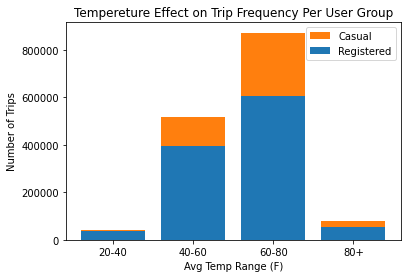

In [25]:
# Display of user type stacked histogram for bike ride frequency for temperature
dpl.plotUserTypeStackData(master_df,
                                 'Tempereture Effect on Trip Frequency Per User Group',
                                 'Avg Temp Range (F)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Number of Trips')

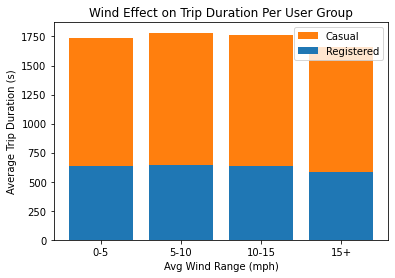

In [26]:
# Display of user type stacked histogram for bike trip duration for wind speed
dpl.plotUserTypeStackData(master_df,
                                 'Wind Effect on Trip Duration Per User Group',
                                 'Avg Wind Range (mph)',
                                 'duration_avg',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Average Trip Duration (s)')

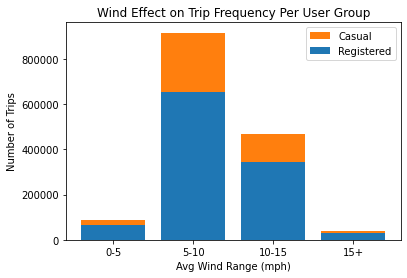

In [27]:
# Display of user type stacked histogram for bike use frequency for wind speed
dpl.plotUserTypeStackData(master_df,
                                 'Wind Effect on Trip Frequency Per User Group',
                                 'Avg Wind Range (mph)',
                                 'use_cnt',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Number of Trips')

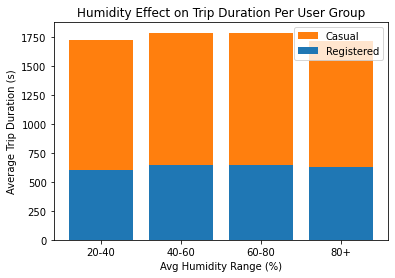

In [28]:
# Display of user type stacked histogram for bike trip duration for humidity
dpl.plotUserTypeStackData(master_df,
                                 'Humidity Effect on Trip Duration Per User Group',
                                 'Avg Humidity Range (%)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Average Trip Duration (s)')

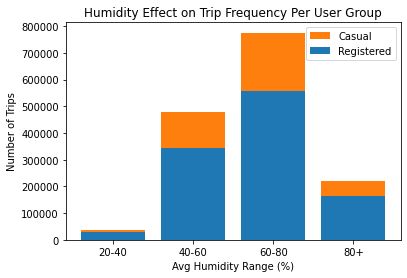

In [29]:
# Display of user type stacked histogram for bike use frequency for humidity
dpl.plotUserTypeStackData(master_df,
                                 'Humidity Effect on Trip Frequency Per User Group',
                                 'Avg Humidity Range (%)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Number of Trips')

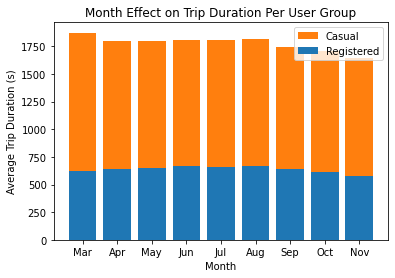

In [30]:
# Display of user type stacked histogram for bike trip duration for month
dpl.plotUserTypeStackData(master_df,
                                 'Month Effect on Trip Duration Per User Group',
                                 'month_start',
                                 'duration_avg',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Average Trip Duration (s)')

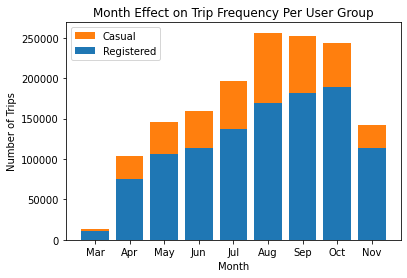

In [31]:
# Display of user type stacked histogram for bike use frequency for month
dpl.plotUserTypeStackData(master_df,
                                 'Month Effect on Trip Frequency Per User Group',
                                 'month_start',
                                 'use_cnt',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Number of Trips')

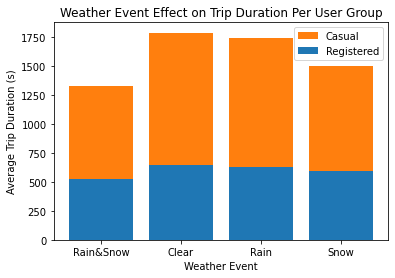

In [32]:
# Display of user type stacked histogram for bike trip duration for weather event
dpl.plotUserTypeStackData(master_df,
                                 'Weather Event Effect on Trip Duration Per User Group',
                                 'Events',
                                 'duration_avg',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Weather Event',
                                 'Average Trip Duration (s)')

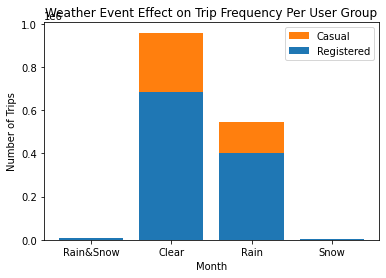

In [33]:
# Display of user type stacked histogram for bike use frequency for weather event
dpl.plotUserTypeStackData(master_df,
                                 'Weather Event Effect on Trip Frequency Per User Group',
                                 'Events',
                                 'use_cnt',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Month',
                                 'Number of Trips')

#### Comparative Analysis per Gender
Key findings:
* Men have significantly higher tendency to ride bike comparing to women, apprx. 80%.
* There is no significant influence of hour of day to trip duration among both genders
* Both genders tend to use bikes around rush hour peaks (07-10h and 16-19h). This could indicate the commute need for bike use during week. (Tip: It could be interesting to observe hourly distributions over different months (i.e. vacation seasonality patterns)).
* As age increases, both genders tend to take longer trips and less frequently.
* Most of bike users belong to 20-40 age group.
* After age 40, women tend decrease more in bike use frequency comparing to men.




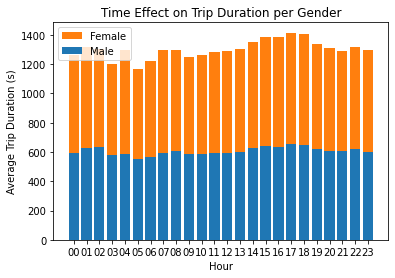

In [34]:
# Display of gender type stacked histogram for bike time duration for hour
dpl.plotUserGenderStackData(master_df,
                                 'Time Effect on Trip Duration per Gender',
                                 'hour_start',
                                 'duration_avg',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Average Trip Duration (s)')

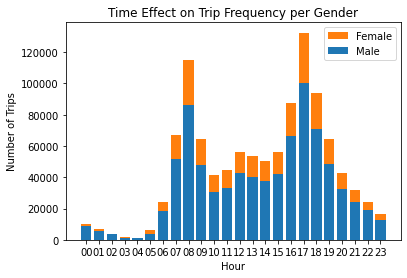

In [35]:
# Display of gender type stacked histogram for bike use frequency for hour
dpl.plotUserGenderStackData(master_df,
                                 'Time Effect on Trip Frequency per Gender',
                                 'hour_start',
                                 'use_cnt',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Number of Trips')

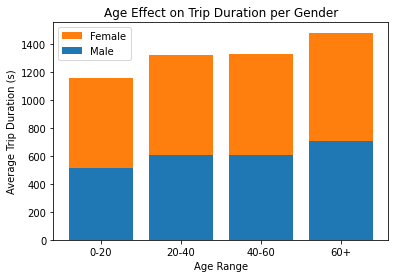

In [36]:
# Display of gender type stacked histogram for bike time duration for age
dpl.plotUserGenderStackData(master_df,
                                 'Age Effect on Trip Duration per Gender',
                                 'Age Range',
                                 'duration_avg',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Average Trip Duration (s)')

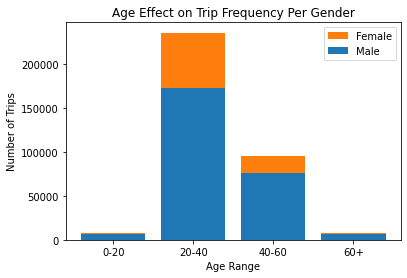

In [37]:
# Display of gender type stacked histogram for bike use frequency for age
dpl.plotUserGenderStackData(master_df,
                                 'Age Effect on Trip Frequency Per Gender',
                                 'Age Range',
                                 'use_cnt',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Number of Trips')

### Step 3: Data pre-processing and Feature Creation

#### Scope 
This section covers feature preparation, data cleaning and variable selection for the model.

In [88]:
# Create subset of variables from master dataset suitable for modeling
feature_set = dpr.featureSubset(master_df)

In [89]:
# Adapt column names to standard naming convention
feature_set = dpr.renameColumns(feature_set)

In [90]:
# Drop events with missing location values
print('Total volume before cleaning: ', len(feature_set))
feature_set = feature_set.drop(feature_set[feature_set['latitude'].isnull()].index)
feature_set = feature_set.drop(feature_set[feature_set['longitude'].isnull()].index)
print('Total volume after cleaning: ', len(feature_set))

Total volume before cleaning:  1512827
Total volume after cleaning:  1512815


In [92]:
# Impute values for missing variables with data
feature_set.loc[feature_set.age.isnull(), "age"] = feature_set.age.mean()
feature_set.loc[feature_set.gender.isnull(), "gender"] = 'NULL'

In [93]:
# Assign 'Category' type for selected variables
feature_set = dpr.setFeatureCategoryType(feature_set)

In [94]:
# Peform K-Means clustering on location data and build 5-category feature
kmeans = KMeans(5)
clusters = kmeans.fit_predict(feature_set[['latitude','longitude']])
feature_set['location_cluster'] = kmeans.predict(feature_set[['latitude','longitude']])
feature_set["location_cluster"] = feature_set["location_cluster"].astype('category')

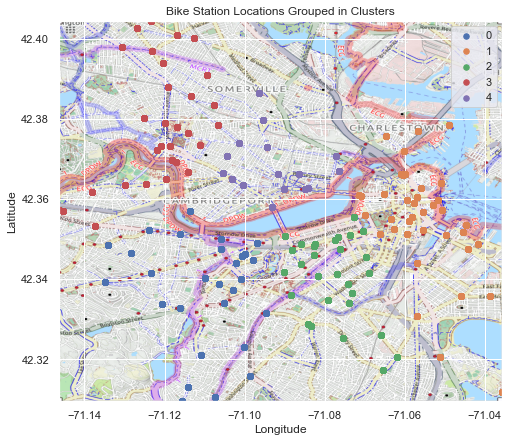

In [95]:
# Display clusters on Boston City map to be used as features in modeling
dpl.plotSpatialDataClusterStations(feature_set, hubway_stations_df)

In [96]:
# Perform One-Hot encoding on category variables
category_features_ohc = pd.get_dummies(feature_set[[
                                                 'subsc_type', 
                                                 'gender',
                                                 'weather_event',
                                                 'location_cluster'
                                                ]])

In [97]:
# Remove category variables from feature set
category_features_ohc = category_features_ohc.drop(columns=['gender_NULL', 'weather_event_None'])

In [98]:
# Remove category variables from feature set
feature_set = feature_set.drop(columns=['staton_municipality',
                                        'subsc_type', 
                                        'gender', 
                                        'avg_dew_point_f',
                                        'bike_freq_use_range',
                                        'bike_avg_dur_range',
                                        'weather_event',
                                        'station_status', 
                                        'trip_status', 
                                        'zip_code',
                                        'location_cluster',
                                        'year',
                                        'latitude',
                                        'longitude'
                                                ])

In [156]:
# Join OHC features to final feature set
# Focus on trip durations below 1000s
# After many trials, trip durations over 1000s decreased model performance significantly
feature_set_ml = feature_set.join(category_features_ohc)
feature_set_ml = feature_set_ml[(feature_set_ml["duration"] > 0) & (feature_set_ml["duration"] <= 1500)]

In [157]:
# List of final features used in ML pipeline
feature_set_ml.columns.T

Index(['month', 'weekday', 'day', 'hour', 'age', 'avg_tmp_f',
       'avg_humidity_pct', 'avg_sea_level_press_in', 'avg_visibility_mi',
       'avg_wind_mph', 'sbowfall_in', 'precip_in', 'duration',
       'subsc_type_Casual', 'subsc_type_Registered', 'gender_Female',
       'gender_Male', 'weather_event_Both', 'weather_event_Rain',
       'weather_event_Snow', 'location_cluster_0', 'location_cluster_1',
       'location_cluster_2', 'location_cluster_3', 'location_cluster_4'],
      dtype='object')

### Step 4: Model Design and Evaluation
#### Scope 
This section covers model selection, configuration, tuning and evaluation.

#### Feature Selection

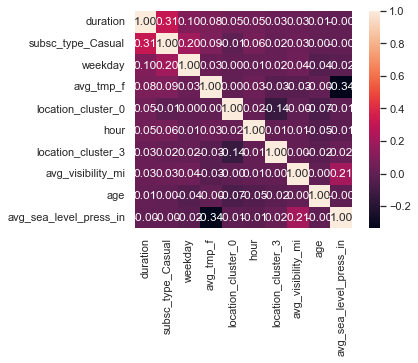

In [158]:
# Picking out the relevant attributes for regression modelling
# Top 10 correlated variables are chosen for final feature set
# As already confirmed through exploratory analysis, 'casual' users have showed highest influence on trip duration 
# Casual users probably pay one-time fee and tend to maximize trip duration for their spent money.
columns = ml.calculateTopCorrelatedColumns(feature_set_ml, 10)
dpl.plotCorrelationHeatMap(feature_set_ml, columns)

In [159]:
# Large duration numbers may affect the absolute numbers of the regression model. 
# To prevent this, target variable will be log-normalized.
# At the end of ML pipeline, reverse operation will be done in order to retrieve original values.
feature_set_ml['duration'] = np.log(feature_set_ml['duration'])

#### Model Selection

In [160]:
# Define feature and target set
X = feature_set_ml[columns]
Y = X['duration'].values
X = X.drop('duration', axis = 1).values

In [161]:
# Split dataset into train (70%) and test (30%) ratios.
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.30, random_state=42)

In [105]:
# Train challenger models with their default parameters
# Following regression models are included in this benchmark:
# LinearRegression
# Lasso
# ElasticNet
# KNeighborsRegressor
# DecisionTreeRegressor
# XGBRegressor
# GradientBoostingRegressor

# The differing scales of the raw data may impact chosen algorithms. 
# Part of a requirement for a standardised data set is for each attribute to have a mean value of zero and a standard deviation of 1. 
# This is implemented within provided function. 
# Cross-validation is used to validate performance of algorithms.
# Model with maximun negative MSE and minimum standard deviation is chosen as a winning model

ml.modelChallengerDefaultParams(X_train, Y_train)

ScaledXGBM: -0.416756 (0.009928)
ScaledLR: -0.414483 (0.008387)
ScaledLASSO: -0.491182 (0.010600)
ScaledEN: -0.491182 (0.010600)
ScaledKNN: -0.483043 (0.008868)
ScaledCART: -0.694894 (0.013379)
ScaledGBM: -0.408345 (0.008669)


#### Model Tuning

In [138]:
# Perform winning model auto hyperparameter tuning 
ml.selectBestModelParams(dict(n_estimators=np.array([50,100,150,200])), xgb.XGBRegressor(random_state=21), X_train, Y_train )

-0.412685 (0.007378) with: {'n_estimators': 50}
-0.417393 (0.007412) with: {'n_estimators': 100}
-0.421874 (0.007482) with: {'n_estimators': 150}
-0.426090 (0.007405) with: {'n_estimators': 200}
Best: -0.412685 using {'n_estimators': 50}


In [180]:
# Train model with best parameters inclding L2 regularization (alpha)
# Increasing L2 will make model more conservative
model = xgb.XGBRegressor(random_state=21, n_estimators=50, alpha=0.2)
model, scaler = ml.trainModel(model, X_train, Y_train)

#### Test and Evaluation

In [181]:
# Run model on unseen test dataset and output MSE
predictions = ml.testModelMSE(model, scaler, X_test, Y_test)

0.35390464239949987


In [182]:
# Comparison of predicted vs real data (scaled)
ml.compareResultsLog(predictions, Y_test)

   Prediction  Test Data
0    6.295389   4.787492
1    6.143008   5.192957
2    6.206981   6.291569
3    6.089144   6.040255
4    6.734056   7.313220
5    6.230320   5.703782
6    6.680049   7.110696
7    6.636098   6.234411
8    6.638338   7.313220
9    6.300134   6.984716


In [183]:
# Reverse scaled predictions to real values and display comparison
ml.compareResultsActual(predictions, Y_test)

   Expected Duration  Predicted Duration  Difference
0                119                 542         422
1                180                 465         285
2                540                 496          43
3                419                 441          21
4               1500                 840         659
5                299                 507         207
6               1224                 796         428
7                509                 762         252
8               1500                 763         736
9               1080                 544         535


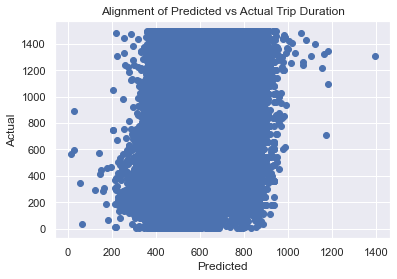

In [184]:
# Plot reversed predictions vs actual trip durations
# Apparently, model does not satisfy fitting criteria
# For a good result, we should get positive correlation trend pattern.
# There is a slight indication for better performance on predicting shorter trip durations
# The advice is not to use the model in final production
plt.scatter(np.exp(predictions), np.exp(Y_test))
plt.title("Alignment of Predicted vs Actual Trip Duration")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()